In [1]:
import warnings
import numpy as np
import pandas as pd 
import matplotlib as mpl
import tensorflow as tf

In [2]:
import statsmodels as sm
from matplotlib import pyplot as plt
from pylab import rcParams

In [7]:
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [8]:
# use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.10.0


## Time Analysis
- Time Series Decomposition
    - Level
    - Trend
    - Seasonality
    - Noise
- Stationary
    - AC and PAC Plots
    - Rolling mean and standard deviation
    - Dickey-Fuller test
- Converting stationary data
    - Difference
    - Log 
    - Smoothing
    - Moving average

### Loading data

In [15]:
air_pollution = pd.read_csv('dataset/air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)
air_pollution.head()

pollution_today        dew       temp        press     wnd_spd  \
date                                                                         
2010-01-02       145.958333  -8.500000  -5.125000  1024.750000   24.860000   
2010-01-03        78.833333 -10.125000  -8.541667  1022.791667   70.937917   
2010-01-04        31.333333 -20.875000 -11.500000  1029.291667  111.160833   
2010-01-05        42.458333 -24.583333 -14.458333  1033.625000   56.920000   
2010-01-06        56.416667 -23.708333 -12.541667  1033.750000   18.511667   

                 snow  rain  pollution_yesterday  
date                                              
2010-01-02   0.708333   0.0            10.041667  
2010-01-03  14.166667   0.0           145.958333  
2010-01-04   0.000000   0.0            78.833333  
2010-01-05   0.000000   0.0            31.333333  
2010-01-06   0.000000   0.0            42.458333

In [17]:
air_pollution.describe()

pollution_today          dew         temp        press      wnd_spd  \
count      1825.000000  1825.000000  1825.000000  1825.000000  1825.000000   
mean         98.245080     1.828516    12.459041  1016.447306    23.894307   
std          76.807697    14.163508    11.552997    10.076053    41.373161   
min           3.166667   -33.333333   -14.458333   994.041667     1.412500   
25%          42.333333   -10.083333     1.541667  1007.916667     5.904167   
50%          79.166667     2.041667    13.916667  1016.208333    10.953750   
75%         131.166667    15.083333    23.166667  1024.541667    22.235000   
max         541.895833    26.208333    32.875000  1043.458333   463.187917   

              snow         rain  pollution_yesterday  
count  1825.000000  1825.000000          1825.000000  
mean      0.052763     0.195023            98.245080  
std       0.546072     0.993917            76.807697  
min       0.000000     0.000000             3.166667  
25%       0.000000     0.000000            42.333333  
50%       0.000000     0.000000            79.166667  
75%       0.000000     0.000000           131.166667  
max      14.166667    17.583333           541.895833

### Preliminary analysis on the plot 

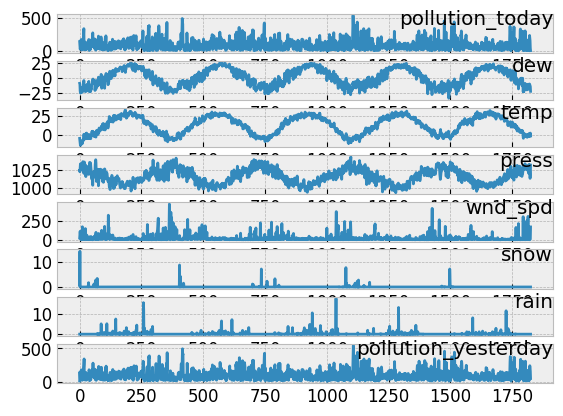

In [22]:
values = air_pollution.values
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1

for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(air_pollution.columns[group], y=0.5, loc='right')
    i += 1


plt.show()

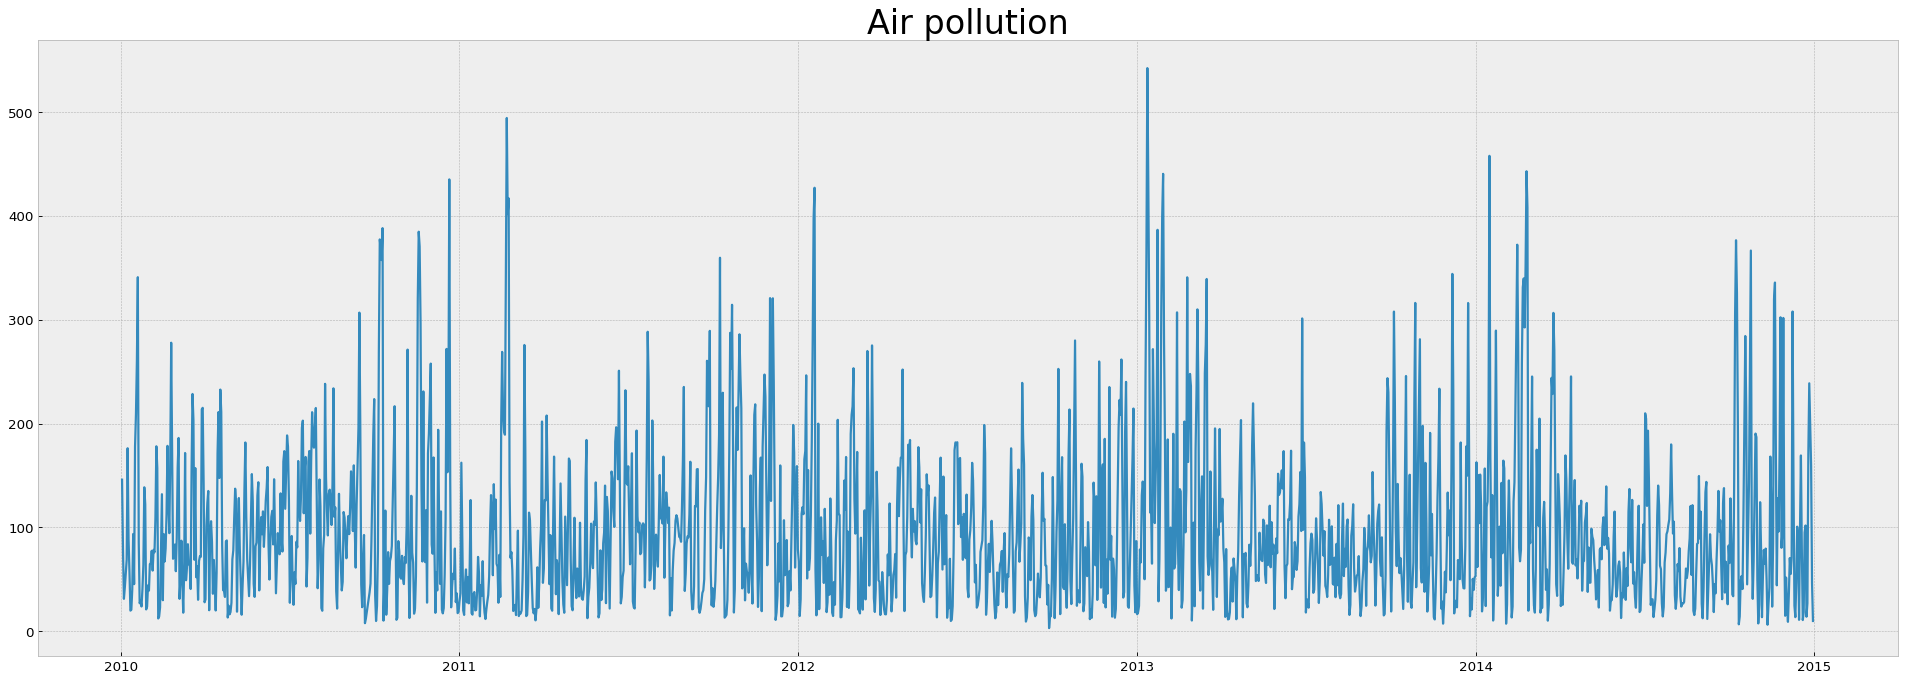

In [23]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Air pollution', fontsize=30)

plt.plot(air_pollution.pollution_today)

## Component of Time Series
- Additive Model - Linear Model  
$ y(t) = Level + Trend + Seasonality + Noise$
    - Linear trend
    - constant variance on trend
    - change is constant over time -> stationary
    
<br/>

- Multiplicative Model - Nonlinear Model  
$ y(t) = Level \times Trend \times Seasonality \times Noise$
    - Curved trend
    - non-constant variance on trend
    - change is not constant over time -> non-stationary

<br/>

- Mixed Model  
Residual: remaining of the original signal after removing the trend and the seasonality  --> typically stationary

### Automatic TS decomposition
Library statsmodel provides a function seasonal_compose() to automatically decompose a time series.  

Which model still needs to be specified

### Training: using Multiplicative Model

1 year air_pollution data from 01/02/2010 to 01/01/2011

In [28]:
air_pollution.pollution_today[:365]

date
2010-01-02    145.958333
2010-01-03     78.833333
2010-01-04     31.333333
2010-01-05     42.458333
2010-01-06     56.416667
                 ...    
2010-12-28     28.166667
2010-12-29     36.625000
2010-12-30     17.583333
2010-12-31     18.666667
2011-01-01     29.000000
Name: pollution_today, Length: 365, dtype: float64

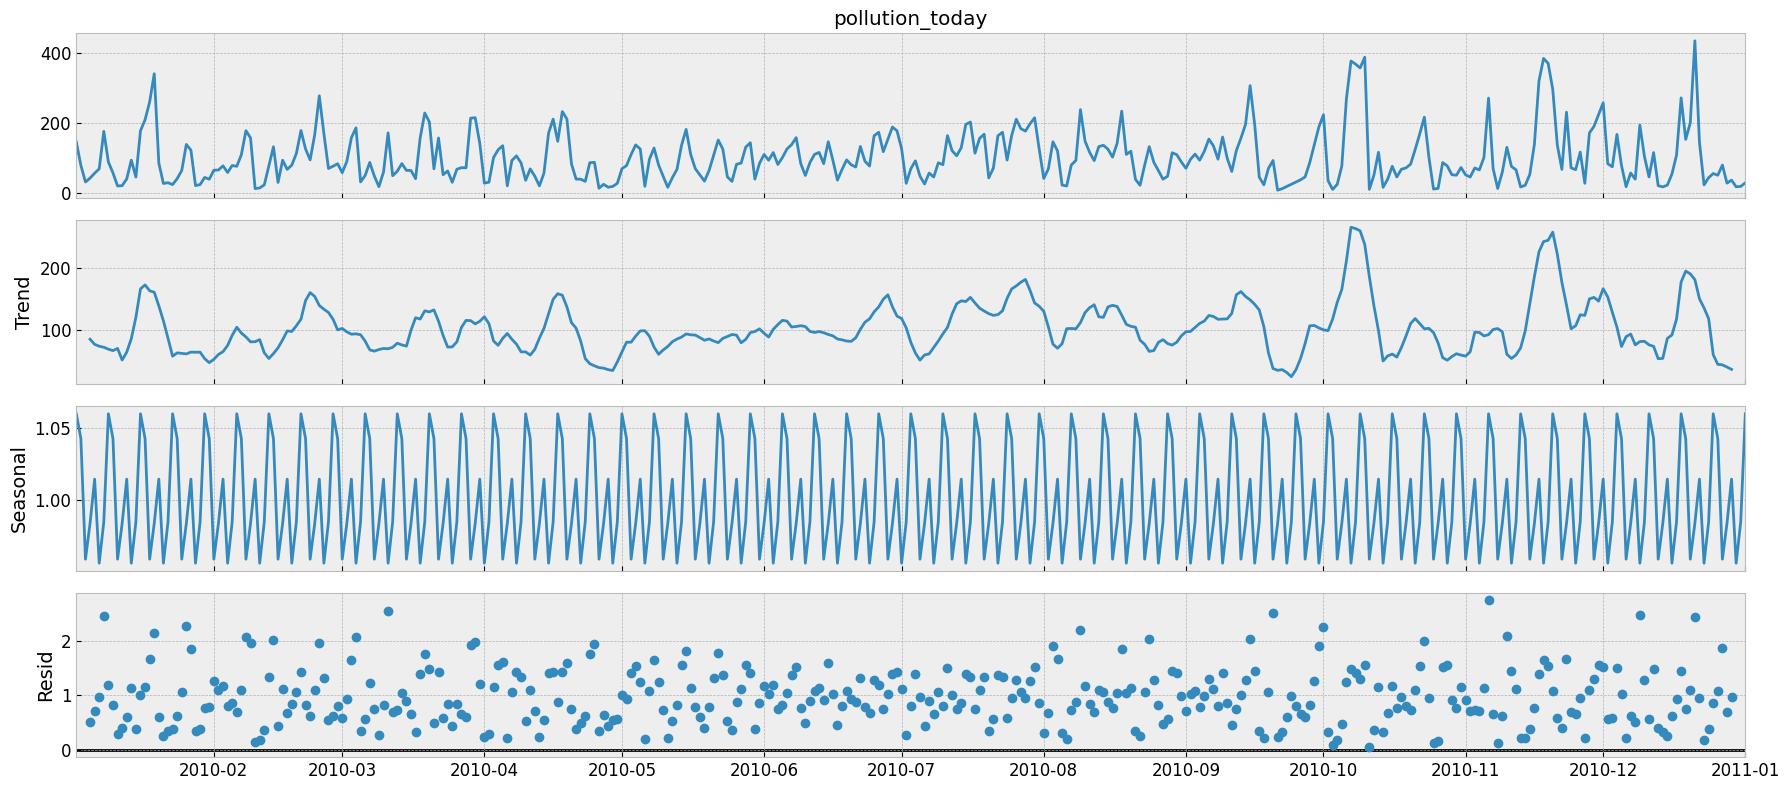

<Figure size 4000x1600 with 0 Axes>

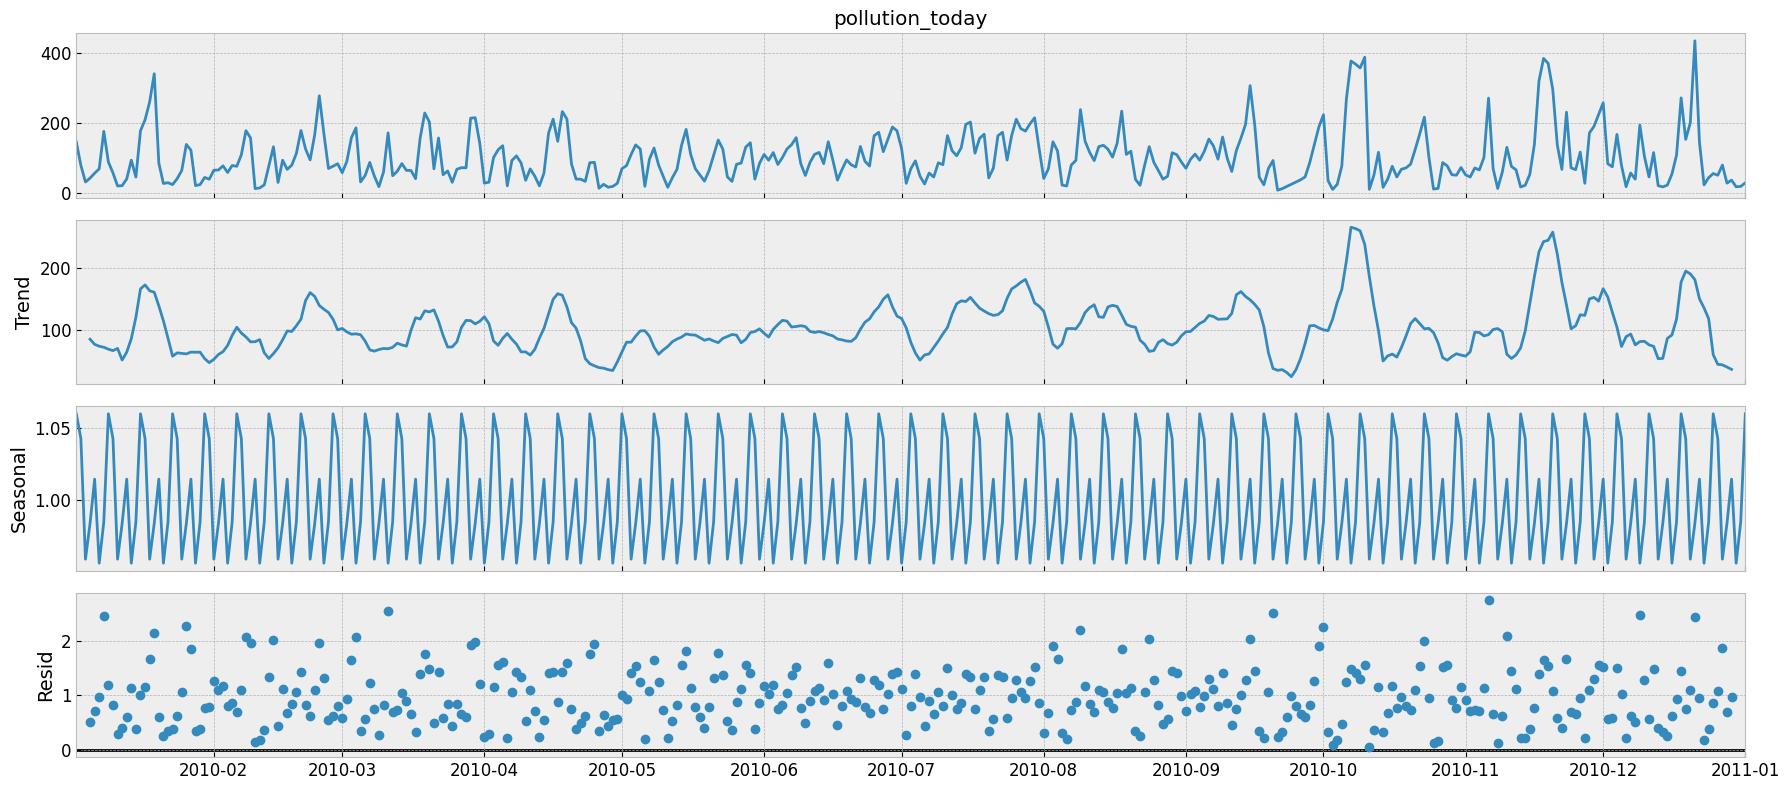

In [25]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')

series = air_pollution.pollution_today[:365]

# de-trend the TS
result = seasonal_decompose(series, model='multiplicative')
result.plot()

### Level
True value after removing the trend, seasonality and the noise. <span style="color:forestgreen">**Value to be predicted by the model**</span>.

### Trend
observed when there is an increase or decrease in the slope

### Checking the trend of the model
- Automatic decomposition
- Moving average
- Fit a linear regression to identify trend

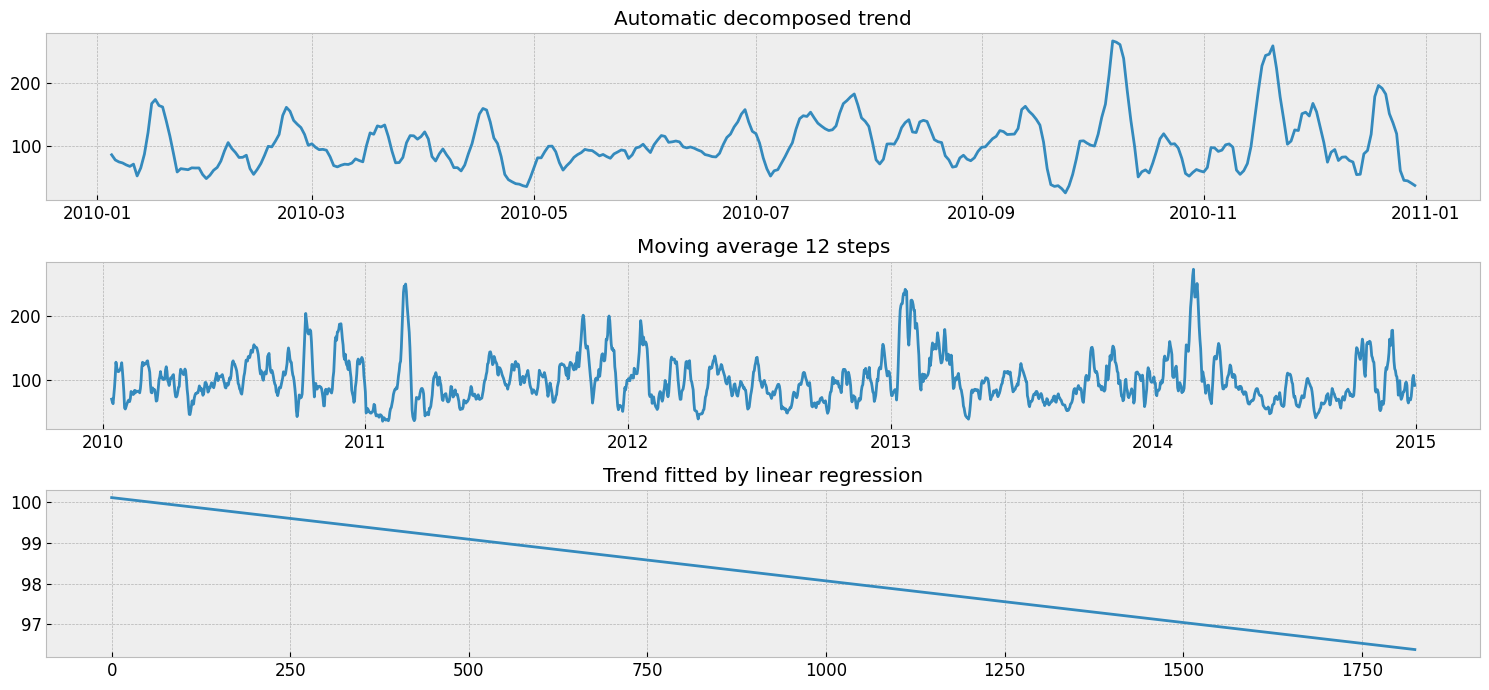

In [40]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 1)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

# 12-months ahead --> rolling(12)
mm = air_pollution.pollution_today.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(air_pollution.pollution_today))]
# creating linear trend / mean
X = np.reshape(X, (len(X), 1))
y = air_pollution.pollution_today.values
model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

No obvious pattern can be observed in the TS. Therefore, Linear regression gives a bad trend prediction.

### Seasonality
Could be in terms of month or year. No regular pattern can be found in automatic decomposition after removing trend.

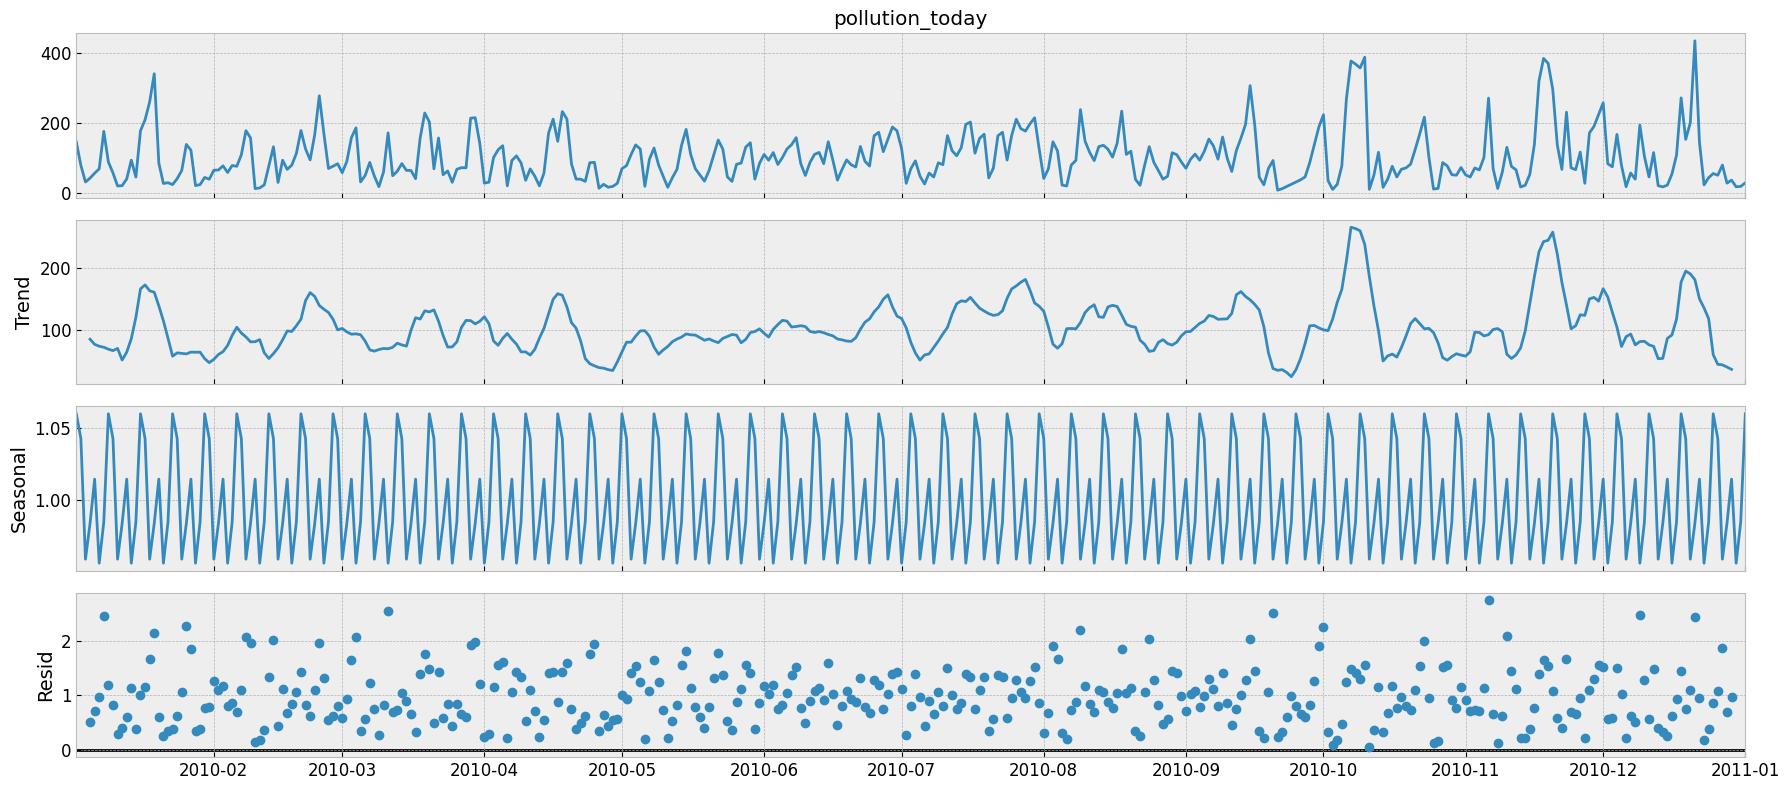

<Figure size 4000x1600 with 0 Axes>

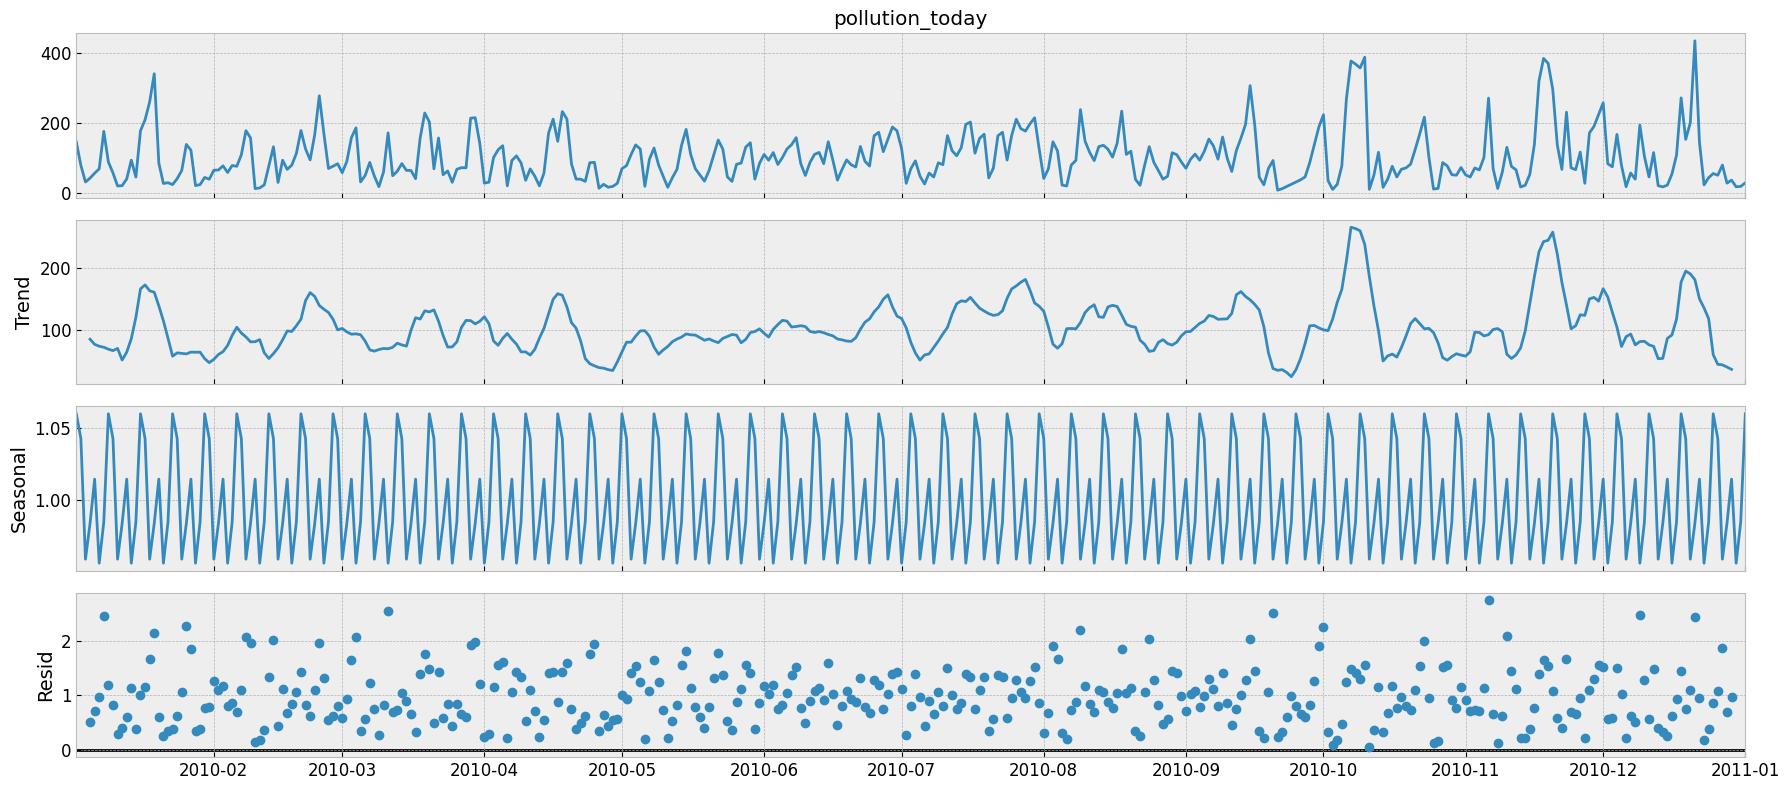

In [65]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot() 


Regular 4 spikes can be found each month between Jan 2010 and Jan 2011, indicating there should be seasonal effect.

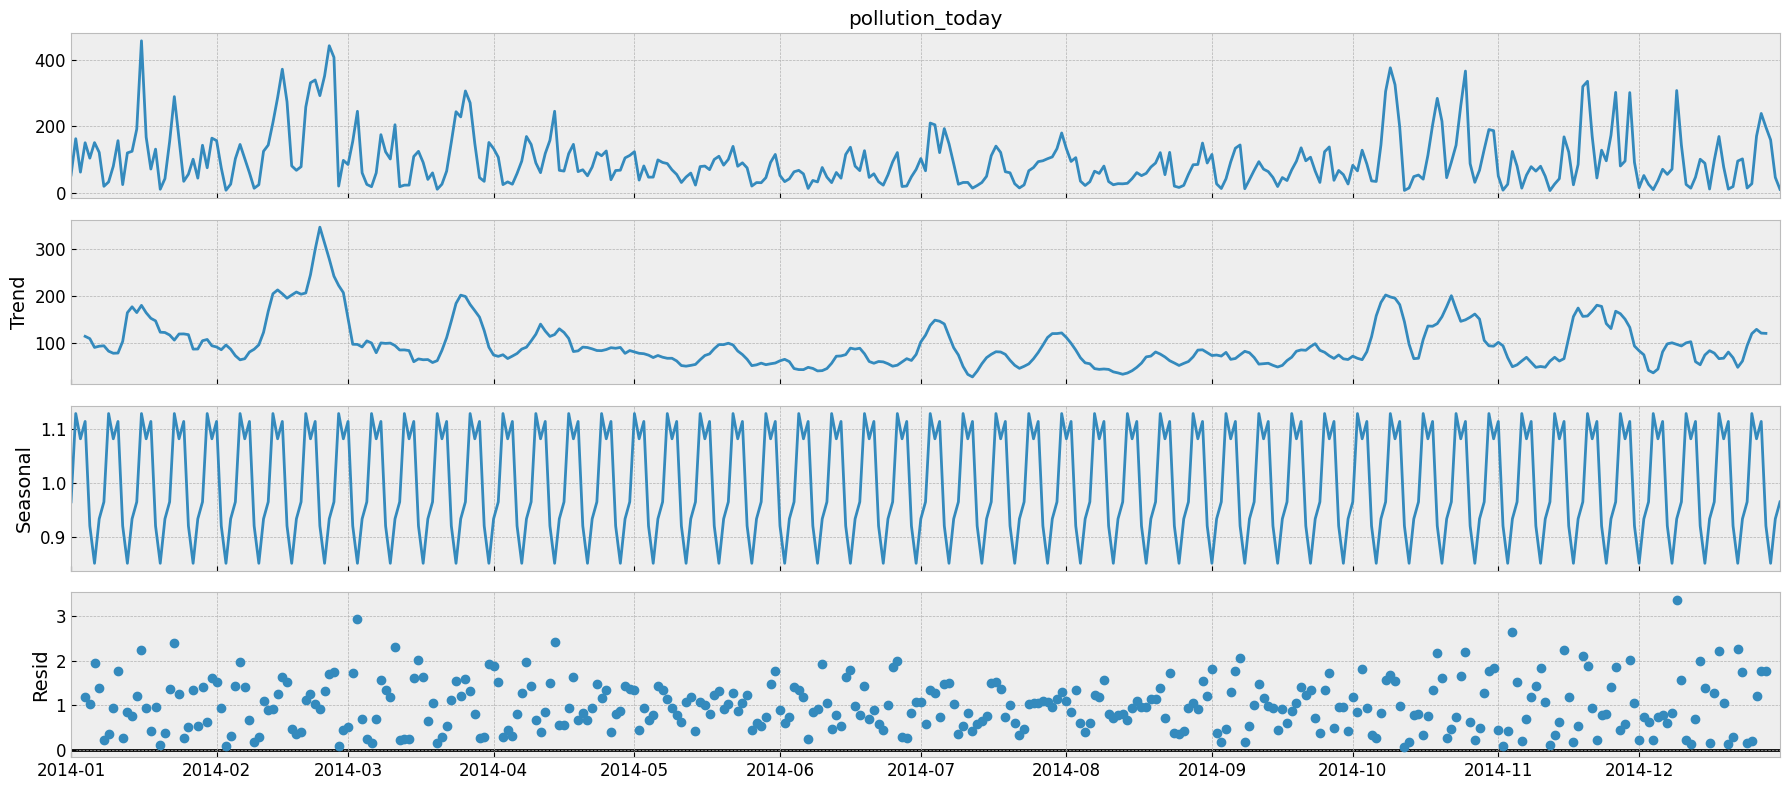

<Figure size 4000x1600 with 0 Axes>

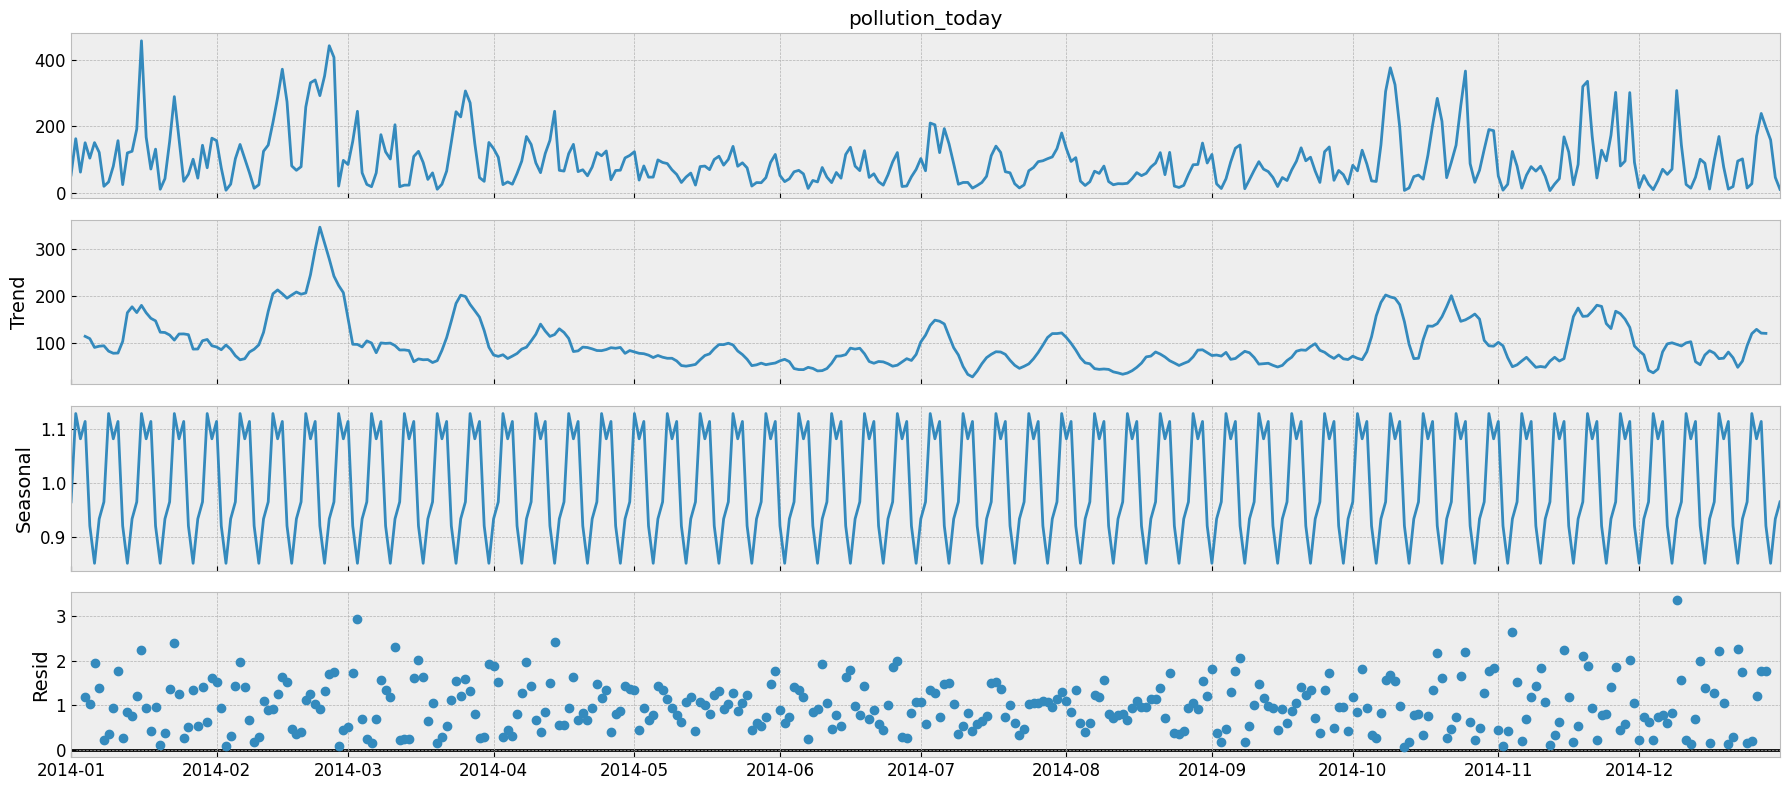

In [66]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[-365:]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

Plot above shows the trend, seasonality of the last 1 year of the dataset. 4 spikes were also observed each month but slightly different in pattern.

### Further look at the Seasonality

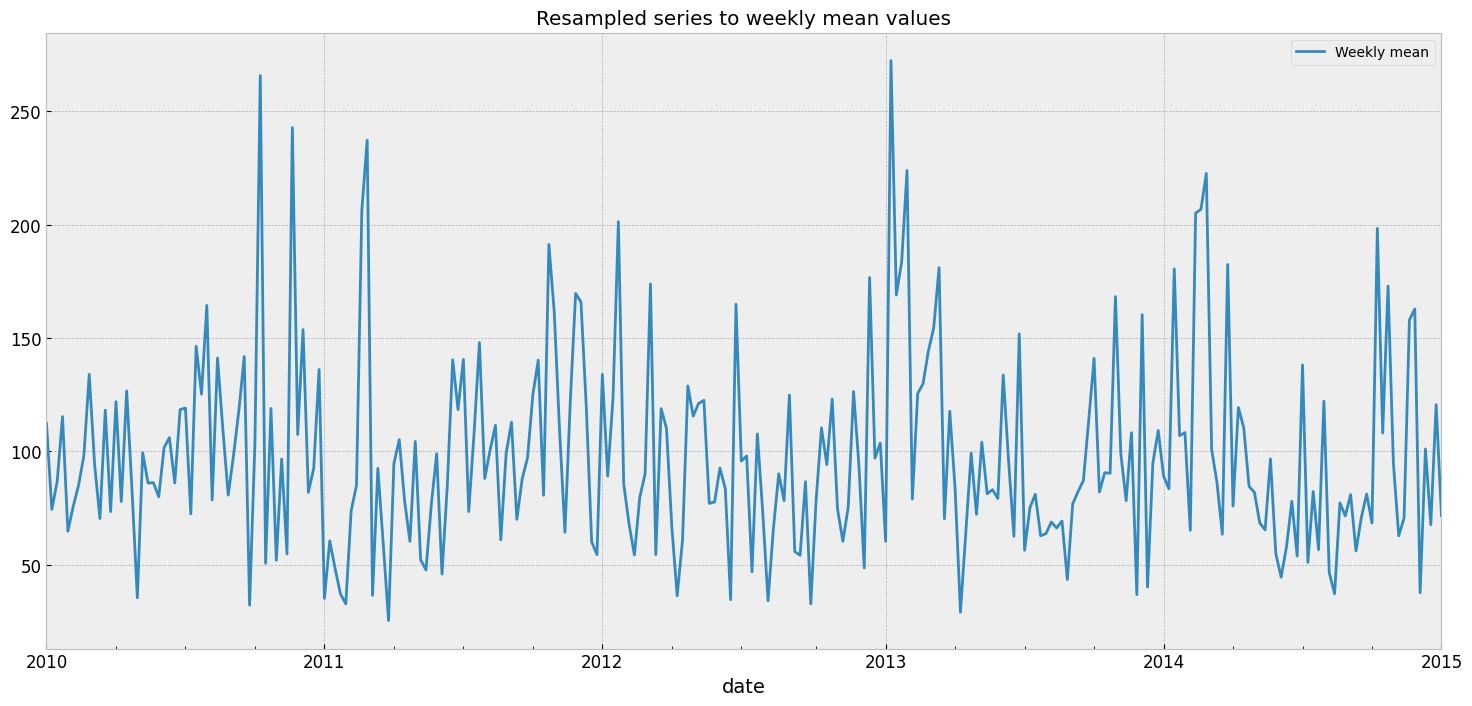

In [67]:
# resample monthly data to weekly data
resample = air_pollution.resample('W')
weekly_mean = resample.mean()

weekly_mean.pollution_today.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

#### manual method

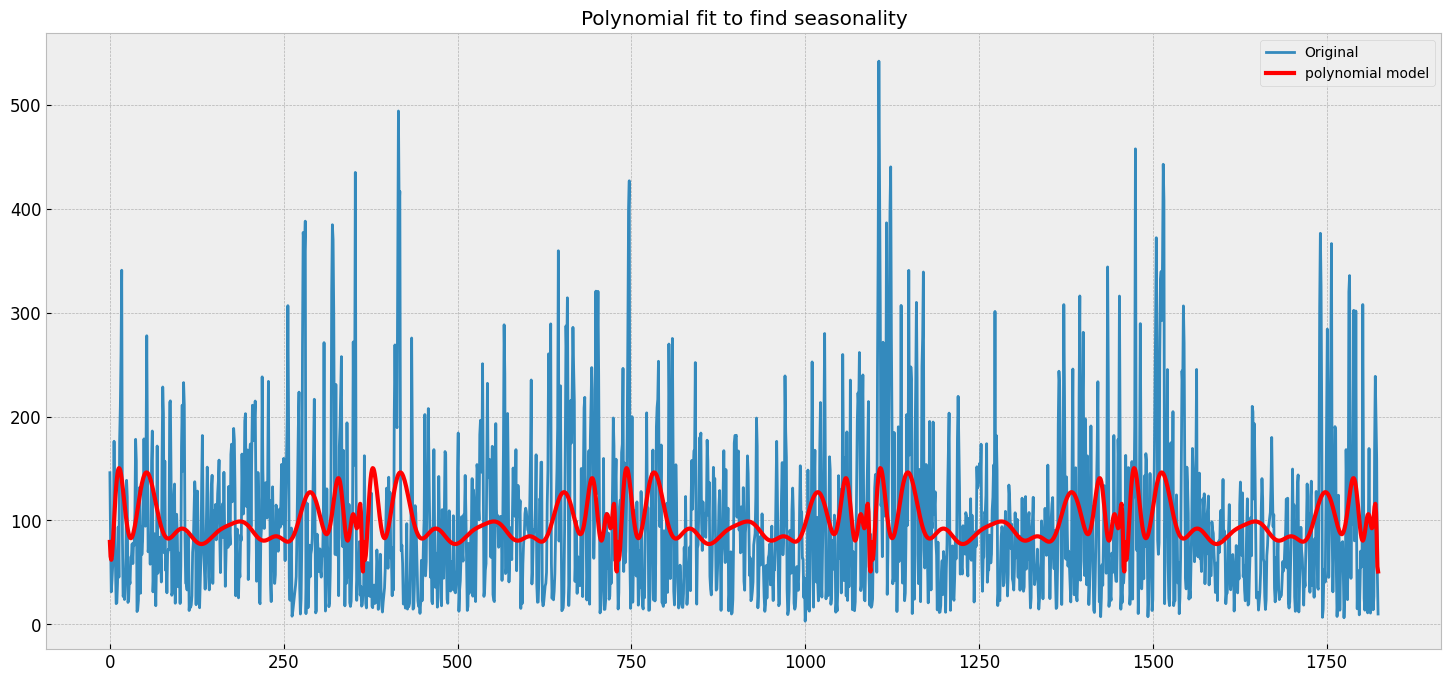

In [74]:
series = air_pollution.pollution_today.values

# list of num from 0 to 364 representing a cyclical
X = [i % 365 for i in range(0, len(series))]
y = series
# degree of poly fit --- polynomial will have 101 coef inc intercept
degree = 100
coef = np.polyfit(X, y, degree)

# poly fit
curve = list()
for i in range(len(X)):
    value = coef[-1]    # initial value - poly fit last coef = constant value
    for d in range(degree):
        # x to power of degree & monomial term
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

# plot curve over original data
plt.plot(series, label='Original')
plt.plot(curve, color='red', linewidth=3, label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

### Noise
white noise: statistically uncorrelated with the rest of the TS
-> E(X) = 0 & V(X) < $\infty$ & E(XY) = 0   

If white noise exist, the TS is random and hence the goal is to minimize the error rather than predicting the TS.  

Checking of the existence of white noise:
- Plot alike Normal distribution with E(X) = 0 & V(X) constant
- Correlation Plot
- Does mean or level change over time?

Text(0.5, 1.0, 'Mean over time')

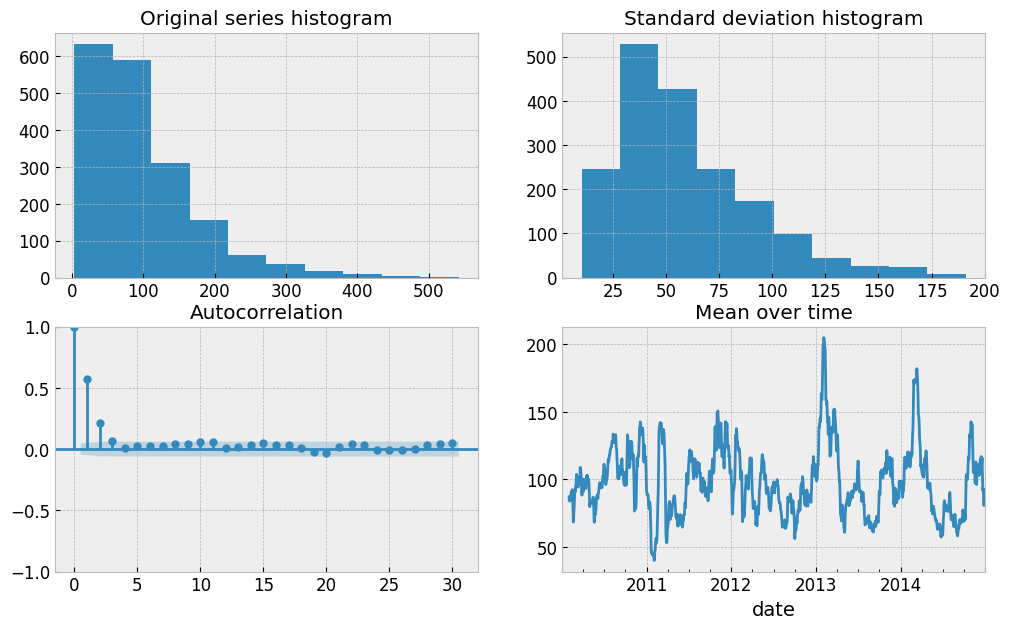

In [79]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

# Original plot
air_pollution.pollution_today.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

# Autocorrelation with 30 lag
plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

# 7 steps ahead - standard deviation
mm = air_pollution.pollution_today.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = air_pollution.pollution_today.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")


Original series and its standard deviation are left skewed with a non-constant mean. There is also slight autocorrelation but it disappear after taking 4 lag. Thus conclude the TS is slightly affected by white noise.

---

## Stationary
- constant mean & variance over time
often transform TS to stationary which makes it easier to model.

Checking: 
Autorcorrelation - degree of correlation at time T with time T+1, T+1, ...  

If TS is stationary, autorcorrelation will decrease rapidly over time --> taking lag can solve stationary problem

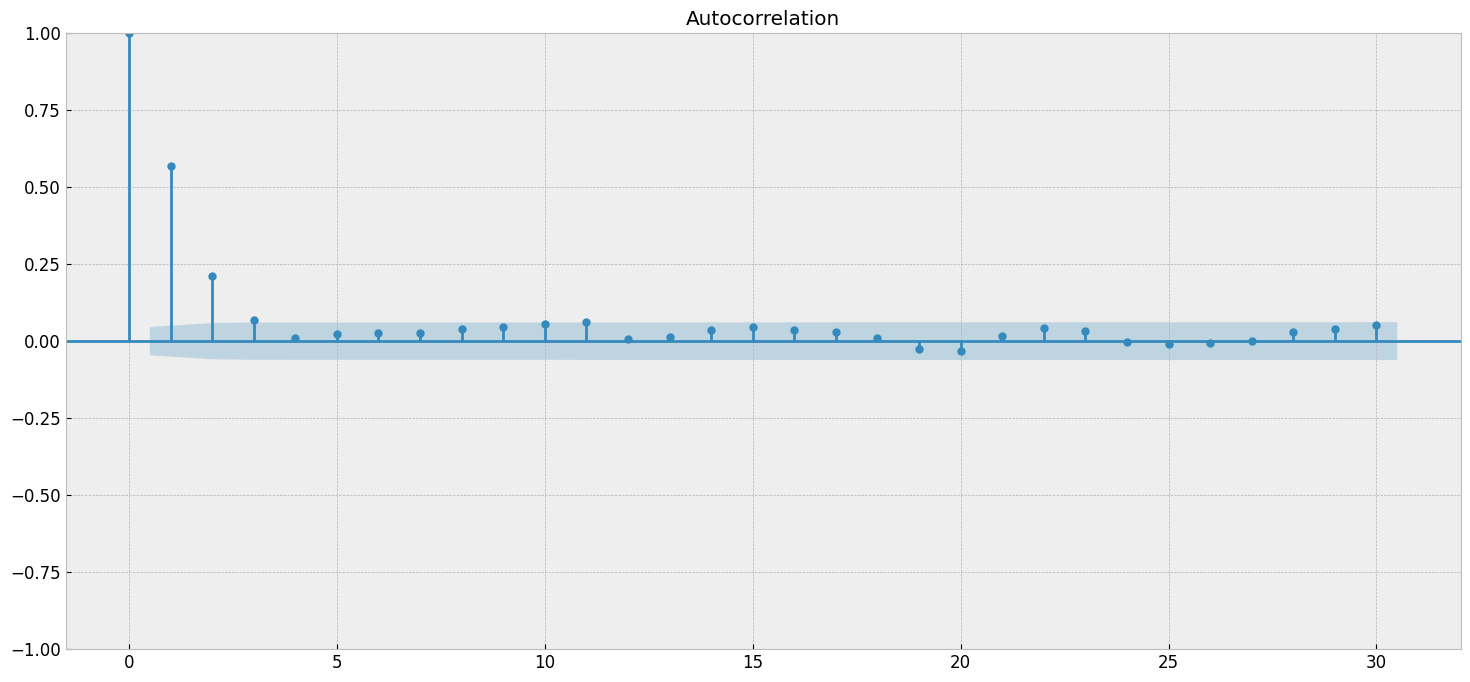

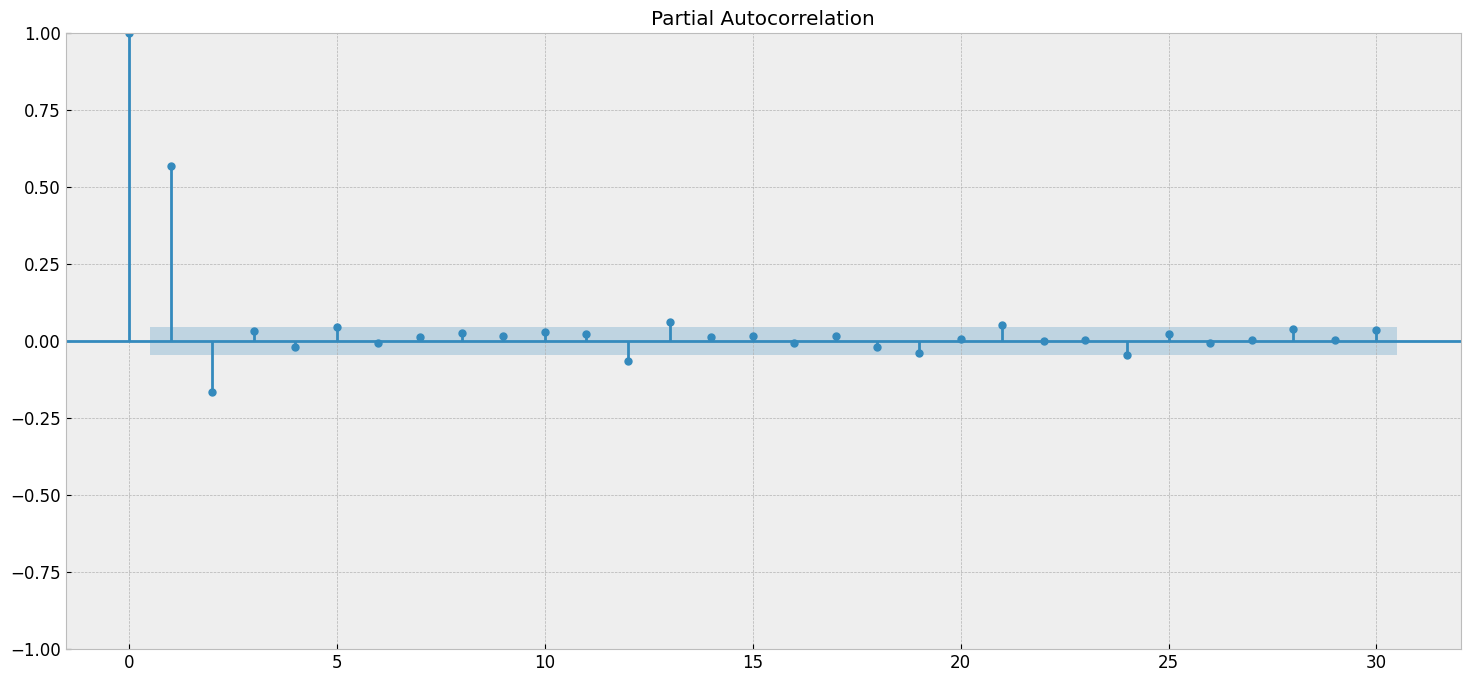

In [80]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

The first plot is stationary because the autocorrelation is bounded after 4th lag.

### Augmented Dickey-Fuller test
ie unit root test which determines how strong the TS is defined by a trend.  
>H0 : unit root / time dependent series/ non-stationary

ideal case: reject H0 to confirm the TS is stationary -- pvlaue less than 5% for 95% test

In [84]:
X = air_pollution.pollution_today.values

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.116719
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


### All combine in one function

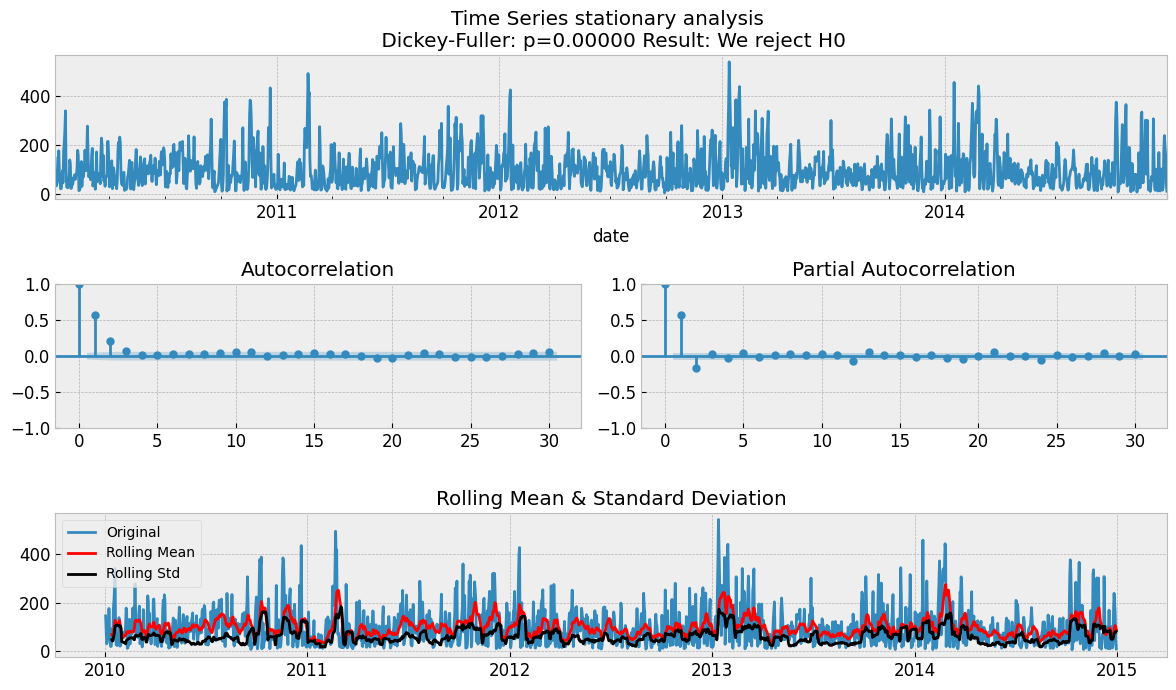

In [89]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    # check if it is in series format
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)

        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject H0" if p_value <= 0.05 else "We can not reject H0"
        ts_ax.set_title(
            'Time Series stationary analysis \n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = air_pollution.pollution_today.rolling(window=12).mean()
        rolstd = air_pollution.pollution_today.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(air_pollution.pollution_today, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(air_pollution.pollution_today, lags=30)

### Treatment of non-stationary
Transform into stationary series:

Text(0.5, 1.0, 'Original vs Windowed mean vs Windowed std')

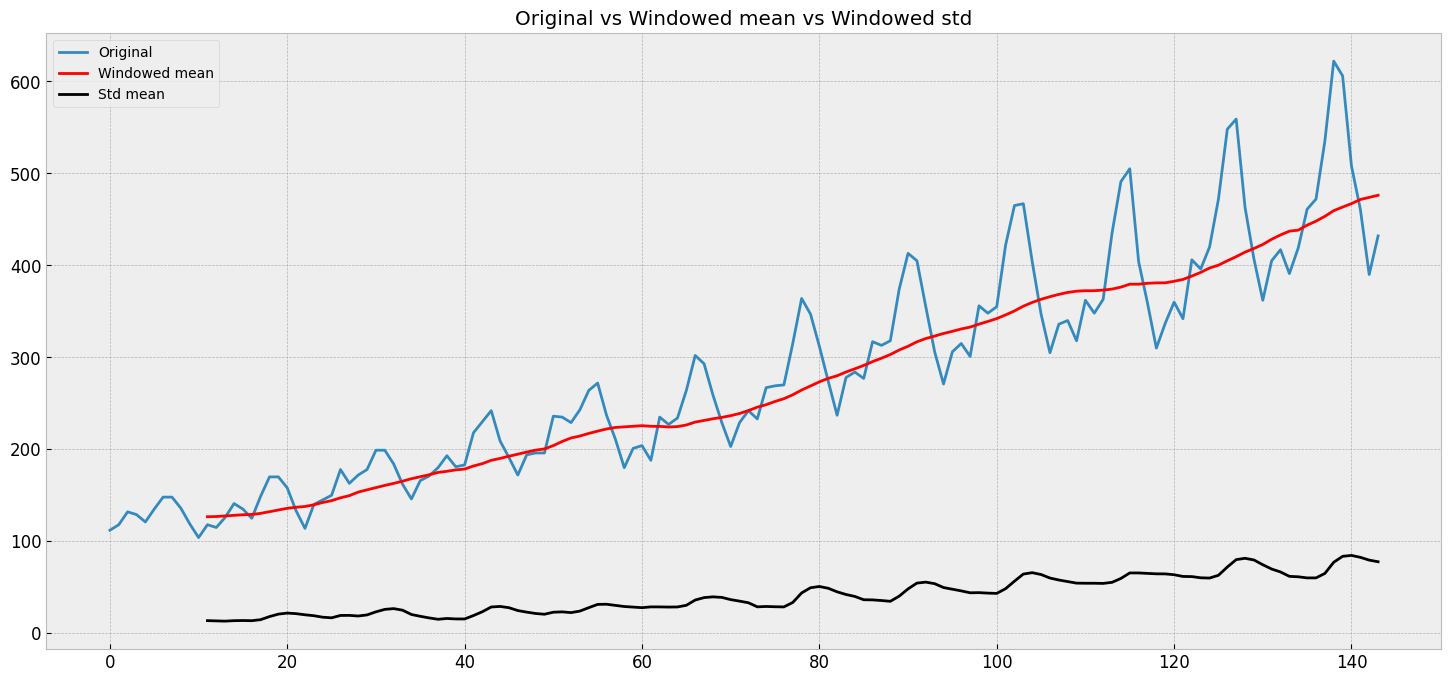

In [87]:
passengers = pd.read_csv("dataset/international_airline_passengers.csv")

passengers.passengers.plot(label='Original')

passengers.passengers.rolling(window=12).mean().plot(
    color='red', label='Windowed mean')

passengers.passengers.rolling(window=12).std().plot(
    color='black', label='Std mean')
plt.legend()
plt.title('Original vs Windowed mean vs Windowed std')

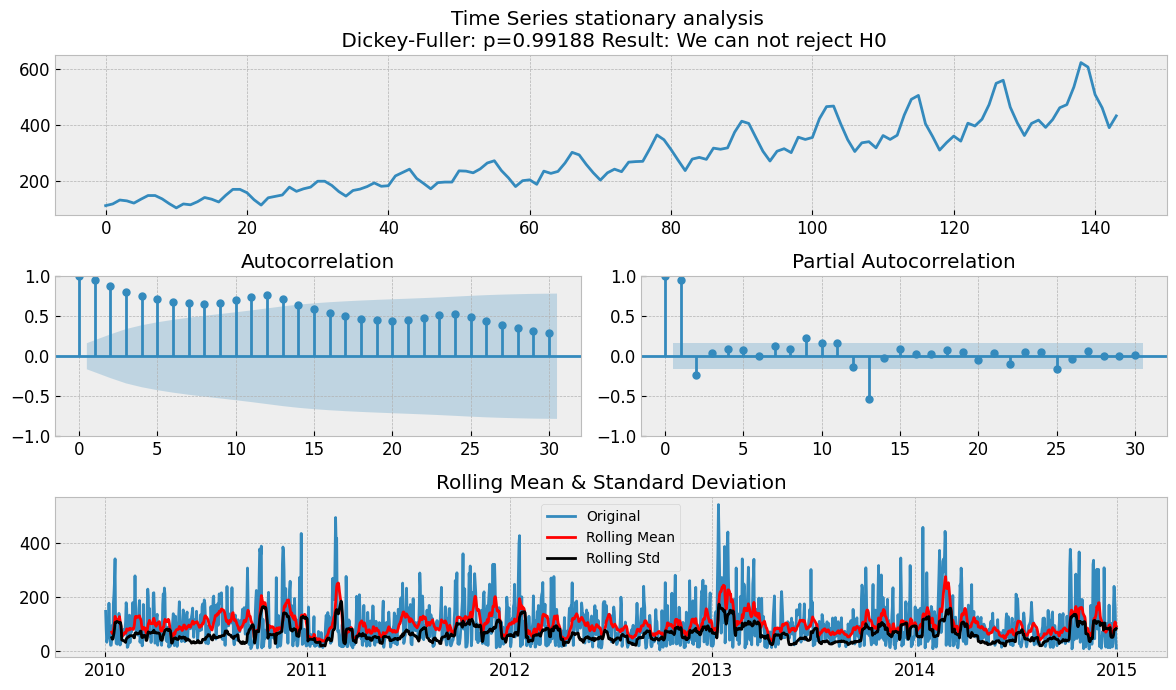

In [90]:
tsplot(passengers.passengers, lags=30)

Above dataset has an increasing mean and the pvalue is greate than 0.05, indicating the high autocorrelation over time. ACF plot supported this finding.  
- Trend: non-constant - increase over time
- Seasonality: some repeated seasonal pattern can be observed

To smooth the trend and seasonality:

1) take Difference  
$$\begin{aligned}
Diff_t = obs_t - obs_{t-1}
\end{aligned}$$
difference between observation and its 1st lag

In [91]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset = diff
    return diff

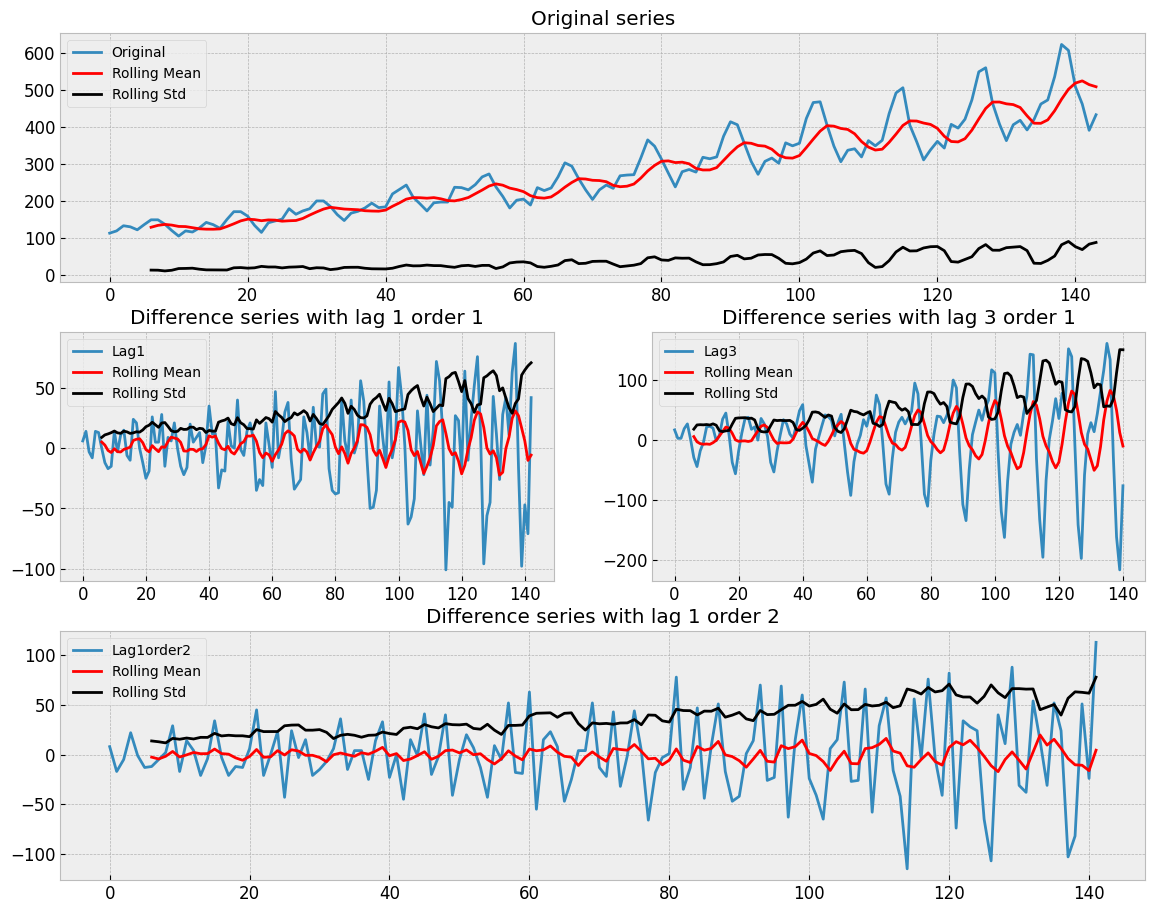

In [92]:
lag1series = pd.Series(difference(passengers.passengers, interval=1, order=1))
lag3series = pd.Series(difference(passengers.passengers, interval=3, order=1))
lag1order2series = pd.Series(difference(passengers.passengers, interval=1, order=2))

fig = plt.figure(figsize=(14, 11))
layout = (3, 2)
original = plt.subplot2grid(layout, (0, 0), colspan=2)
lag1 = plt.subplot2grid(layout, (1, 0))
lag3 = plt.subplot2grid(layout, (1, 1))
lag1order2 = plt.subplot2grid(layout, (2, 0), colspan=2)

original.set_title('Original series')
original.plot(passengers.passengers, label='Original')
original.plot(passengers.passengers.rolling(7).mean(), 
              color='red', label='Rolling Mean')
original.plot(passengers.passengers.rolling(7).std(),
              color='black', label='Rolling Std')
original.legend(loc='best')

# Lag 1 order 1
lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label="Lag1")
lag1.plot(lag1series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(7).std(), color='black', label='Rolling Std')
lag1.legend(loc='best')

# Lag 3 order 1
lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label="Lag3")
lag3.plot(lag3series.rolling(7).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(7).std(), color='black', label='Rolling Std')
lag3.legend(loc='best')

# Lag 1 order 2
lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label="Lag1order2")
lag1order2.plot(lag1order2series.rolling(7).mean(),
                color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(7).std(),
                color='black', label='Rolling Std')
lag1order2.legend(loc='best')

1st order diff remove stationary nicely but taking 2nd order restore the stationary again 

### Log scale
Log transforming TS can also help removing time dependence

Text(0.5, 1.0, 'Log scale transformation into original series')

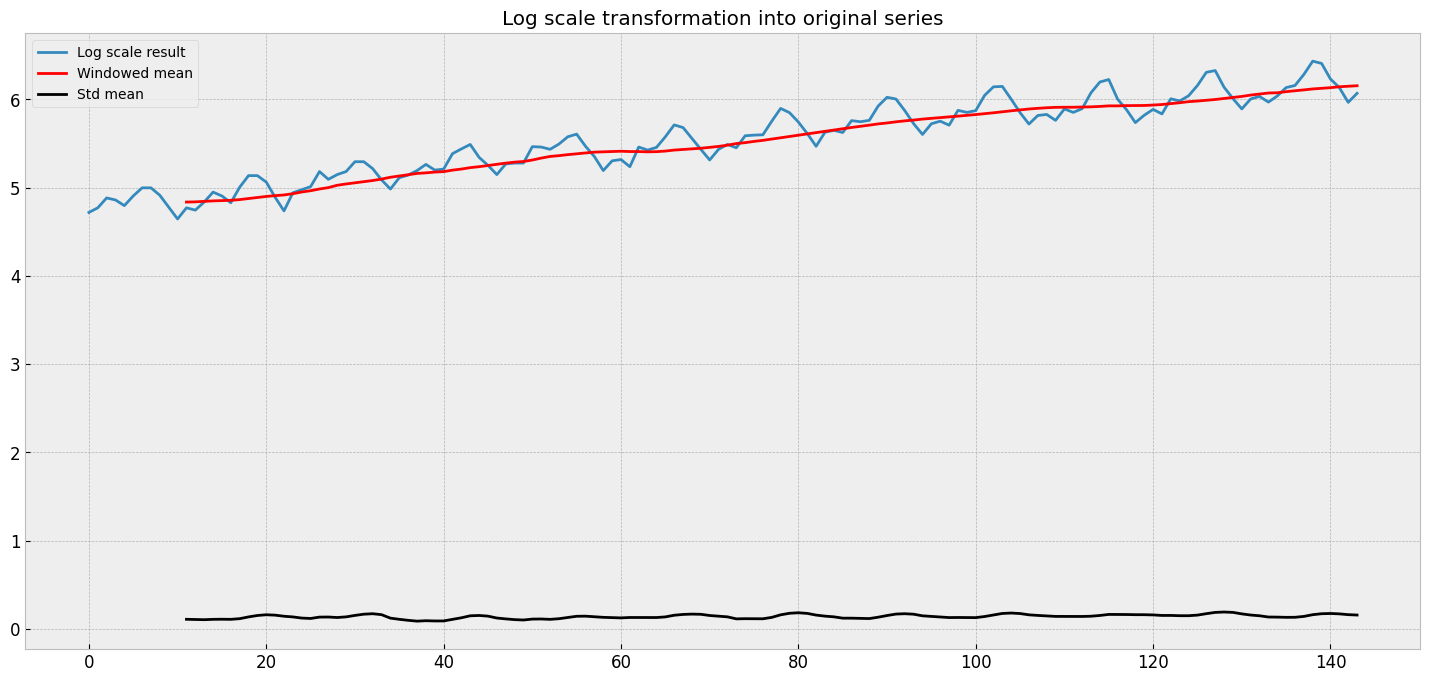

In [93]:
ts_log = np.log(passengers.passengers)

ts_log.plot(label='Log scale result')
ts_log.rolling(window=12).mean().plot(color='red', label='Windowed mean')
ts_log.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Log scale transformation into original series')

---

## MA to Smoothing
MA can be used to smooth seasonality apart from checking stationarity

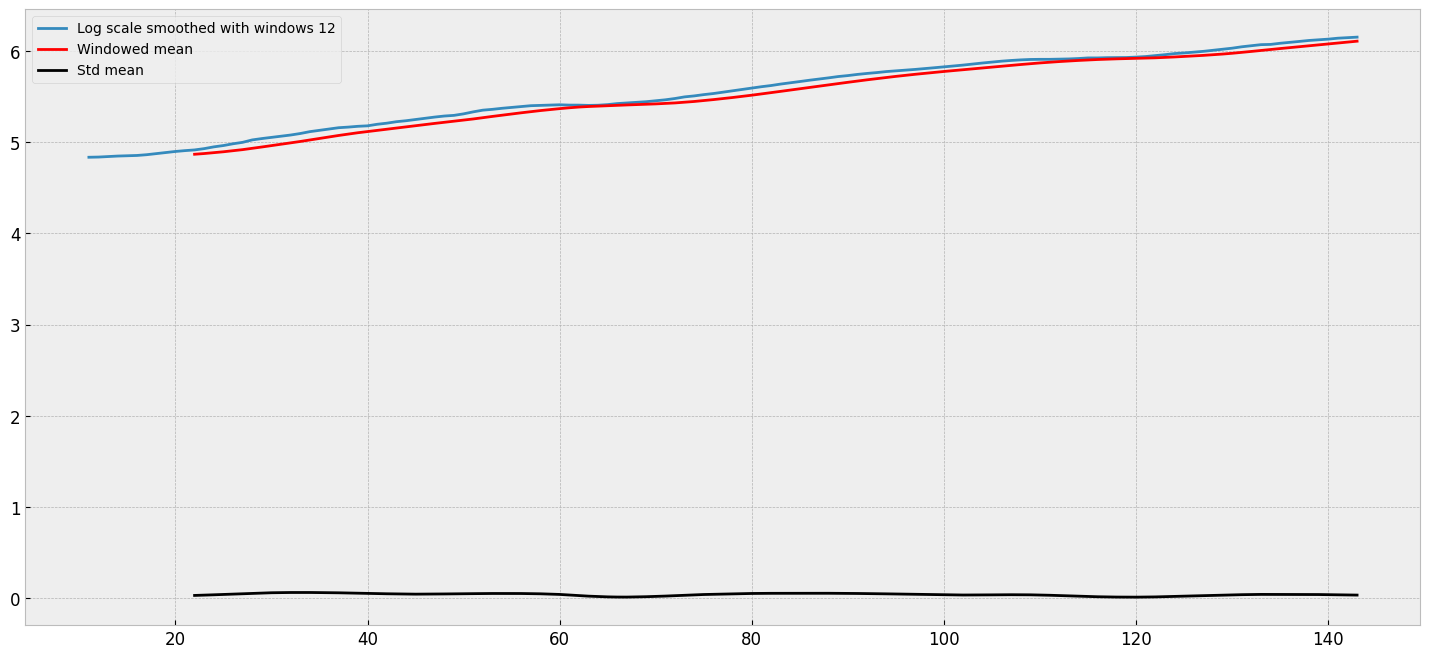

In [94]:
# MA mean with window of 12
avg = pd.Series(ts_log).rolling(12).mean()

plt.plot(avg, label='Log scale smoothed with windows 12')

# mean of MA (mean)
avg.rolling(window=12).mean().plot(color='red', label='Windowed mean')
avg.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()

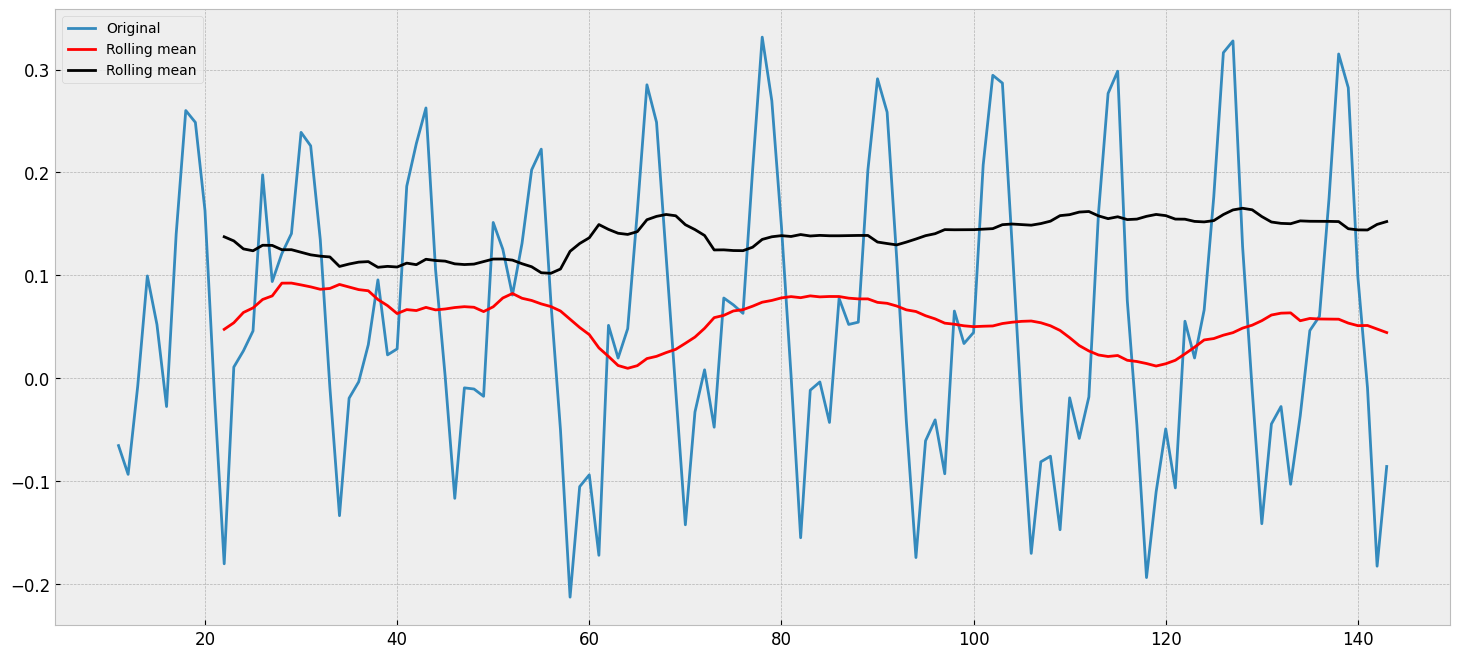

In [95]:
# log scale + 1st diff
ts_log_moving_avg_diff = ts_log - avg

ts_log_moving_avg_diff.plot(label='Original')

ts_log_moving_avg_diff.rolling(12).mean().plot(
    color='red', label="Rolling mean")

ts_log_moving_avg_diff.rolling(12).std().plot(
    color='black', label="Rolling mean")
plt.legend(loc='best')

---

## Windowing
Sliding windows to evaluate if the specific quantities are time varying.  

&nbsp; Example: width = 6 on length = 11 

$$\begin{aligned}
{x_{0}|x_{1}|x_{2}|x_{3}|x_{4}|x_{5}}\\
{x_{1}|x_{2}|x_{3}|x_{4}|x_{5}|x_{6}}\\
{x_{2}|x_{3}|x_{4}|x_{5}|x_{6}|x_{7}}\\  
{x_{3}|x_{4}|x_{5}|x_{6}|x_{7}|x_{8}}\\  
{x_{4}|x_{5}|x_{6}|x_{7}|x_{8}|x_{9}}\\  
{x_{5}|x_{6}|x_{7}|x_{8}|x_{9}|x_{10}}
\end{aligned}$$

#### Lost Value
part of the TS 'lost' when calculating running average. The length depends on the width of the window  
&nbsp; Example: width = 6 on length = 11 -- lost first 6 data for calculating the 1st running average  

Lost Value of the TS: place at the beginning to avoid 'future leaking' when splitting the dataset


#### Bollinger Bands
$\mu_{N} \pm K\sigma_{N}$  
- N: number of period
- $\mu_{N}: moving average$
- K: number of standard deviations   

If TS not bounded by Bollinger Bands = change in temporal behavior  
&nbsp; Eg Stock: N=20, K=2

#### Exponential Running Average
Exponential Smoothing:  
$$\begin{aligned}
z_{t} = \alpha x_{t}+(1-\alpha)z_{t-1}
\end{aligned}$$

- $\alpha$: Weight of influence each point has over the transformed TS  
--> smaller $\alpha$: smoother TS, less consideration on far away points

All points depends on **ALL** previous points  
$$
\begin{pmatrix}
x_{0} \dots x_{5}\\ 
x_{0} \dots x_{6}\\
x_{0} \dots x_{7}\\
\vdots\\
x_{0} \dots x_{10}\
\end{pmatrix} 
=
\begin{pmatrix}
\alpha\\ 
\alpha(1-\alpha)^1 & \alpha\\
\alpha(1-\alpha)^2 & \alpha(1-\alpha)^1 & \alpha\\
\vdots & \vdots & \vdots & \ddots\\
\alpha(1-\alpha)^{n-1} & \alpha(1-\alpha)^{n-2} & \alpha(1-\alpha)^{n-3} & \alpha\\
\end{pmatrix}$$